In [1]:
# Evaluation of reconstructed proteomic profiles by Spatial-DC on HumanTonsil data without Noise
# Yuan
# 20241128

In [2]:
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr,spearmanr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mat
import os
import sys
from scipy import stats

import cell2location
import matplotlib.colors as mcolors

import warnings
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# Cell-Cell communication analysis
import gc
import ot
import pickle
from scipy import sparse
from scipy.spatial import distance_matrix

import commot as ct
warnings.filterwarnings("ignore")

plt.rcParams['font.size'] = 10
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42



/data/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
Global seed set to 0
2024-11-28 19:51:12.945072: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Visualization of reconstruction results
- Fig. 2i - k

         Falling back to preprocessing with `sc.pp.pca` and default params.


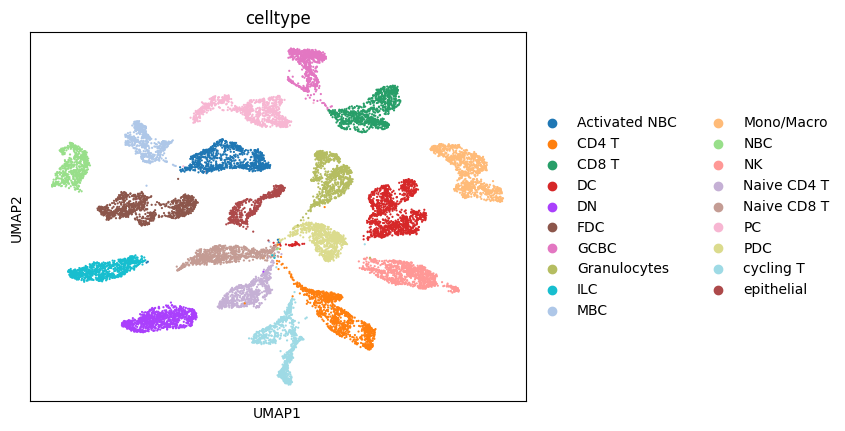

In [43]:
#------------------ UMAP
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/HumanTonsil2023/02_proteomic_profiles")
scp_adata = sc.read_h5ad("03_benchmark_methods/exp_ref46/SpatialDC/SpatialDC_reconstruct_norm.h5ad")

sc.pp.filter_cells(scp_adata, min_counts=10)
sc.pp.filter_genes(scp_adata, min_cells=3)

scp_adata = scp_adata[scp_adata.obs["cellperc"] > 0.01]

# 16214 × 174
sc.pp.normalize_total(scp_adata)
sc.pp.log1p(scp_adata)
# sc.pp.pca(scp_adata)
sc.pp.neighbors(scp_adata)
sc.tl.umap(scp_adata)

# sc.tl.leiden(scp_adata,resolution=0.2)
sc.pl.umap(scp_adata, color=['celltype'],size=10,save="_reconstructed_ct19.pdf")

In [53]:
scp_adata

AnnData object with n_obs × n_vars = 16214 × 174
    obs: 'ID', 'celltype', 'X', 'Y', 'cellperc', 'n_counts'
    var: 'name1', 'name2', 'name3', 'pid', 'ref', 'group', 'n_cells'
    uns: 'log1p'

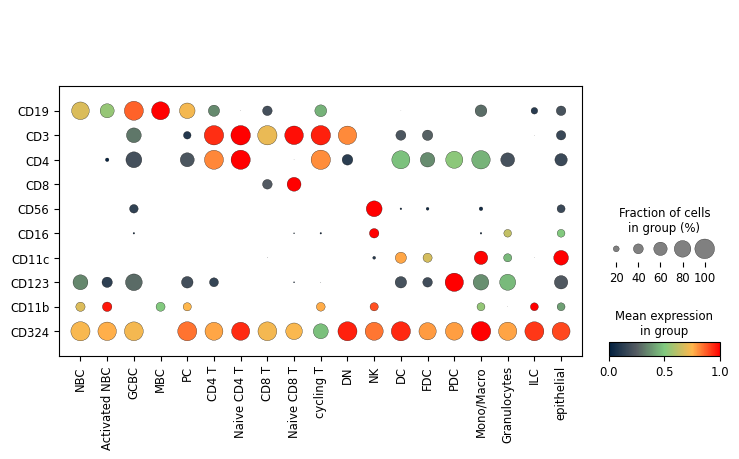

In [52]:
# vis of known-marker proteins
# Fig. S9d
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/HumanTonsil2023/02_proteomic_profiles")
scp_adata = sc.read_h5ad("03_benchmark_methods/exp_ref46/SpatialDC/SpatialDC_reconstruct_norm.h5ad")

sc.pp.filter_cells(scp_adata, min_counts=10)
sc.pp.filter_genes(scp_adata, min_cells=3)
scp_adata = scp_adata[scp_adata.obs["cellperc"] > 0.01]

sc.pp.normalize_total(scp_adata)
sc.pp.log1p(scp_adata)
# sc.pp.scale(scp_adata)


ct_order = ['NBC','Activated NBC','GCBC','MBC', 'PC',
              'CD4 T', 'Naive CD4 T','CD8 T','Naive CD8 T', 'cycling T', 'DN', 'NK', 
              'DC','FDC','PDC',  'Mono/Macro',  'Granulocytes', 
       'ILC',  'epithelial']

scp_adata.obs["celltype"] = scp_adata.obs["celltype"].cat.set_categories(ct_order,ordered=False)


colors = ['#001f3f', '#545b62', '#7fc97f', '#ffb74d', 'red']
my_cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors)

markers_list = ["CD19",#B"    
    "CD3","CD4","CD8", # T cells
    "CD56","CD16",#NK
    "CD11c","CD123",#cDC,pDC
    "CD11b",
    "CD324",
]
ax=sc.pl.dotplot(scp_adata, markers_list,return_fig=True, groupby='celltype', swap_axes=True,standard_scale="var", cmap=my_cmap)
# ax.show()
ax.savefig("figures/HumanTonsil_selected_markers.pdf")

# cell-cell communication analysis

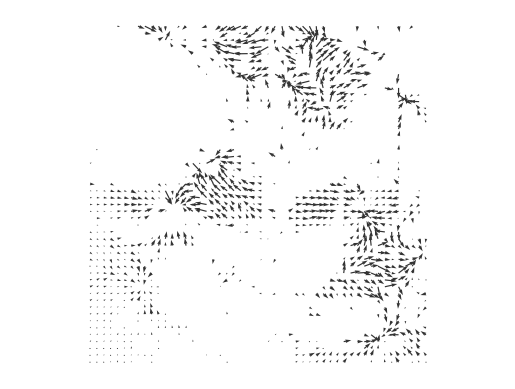

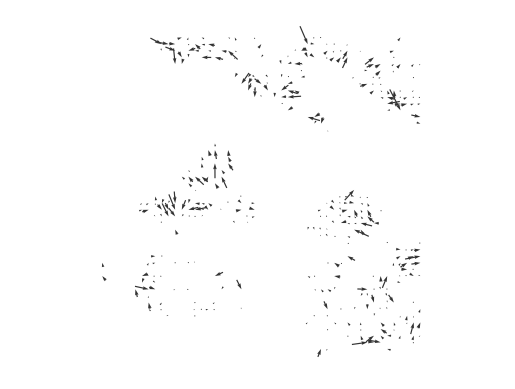

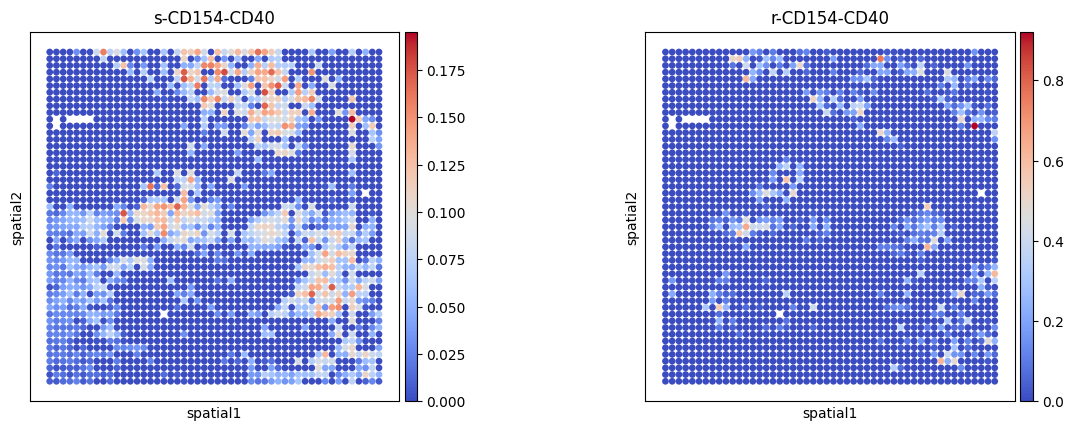

In [45]:
# T4 - ANBC
# CCC analysis
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/HumanTonsil2023/02_proteomic_profiles")
scp_adata = sc.read_h5ad("03_benchmark_methods/exp_ref46/SpatialDC/SpatialDC_reconstruct_not_norm.h5ad")
 
# set zero of cellperc<0.01
set_zero = scp_adata.obs["cellperc"] < 0.01
temp_arr = np.array(scp_adata.to_df())
temp_arr[set_zero,:]=0
scp_adata.X = temp_arr

sender_cell = "CD4 T"
sender_pid = "CD154" # CD40L
receiver_cell = "Activated NBC"
receiver_pid = "CD40"

keep_index = scp_adata.var["name2"].isin([sender_pid,receiver_pid])
keep_ct = scp_adata.obs["celltype"].isin([sender_cell])
target_adata = scp_adata[keep_ct,keep_index].copy()

temp_index = [f"spot_{i}" for i in range(target_adata.shape[0])]
target_adata.obs.index = temp_index

temp_df = target_adata.to_df()

keep_index = scp_adata.var["name2"].isin([receiver_pid])
keep_ct = scp_adata.obs["celltype"].isin([receiver_cell])
temp_df[receiver_pid]  = scp_adata[keep_ct,keep_index].to_df().values
target_adata.X = np.array(temp_df)

# prepare adata
target_adata.obs[["Y"]] = -target_adata.obs[["Y"]]
target_adata.obsm["spatial"] = np.array(target_adata.obs[["X","Y"]])
sc.pp.log1p(target_adata)

target_ppi_df = pd.DataFrame({0:sender_pid,1:receiver_pid,2:'sig_ppi',3:'Secreted Signaling'},index=[0,1,2,3])
ct.tl.spatial_communication(target_adata,
    database_name='selected_db', df_ligrec=target_ppi_df, dis_thr=500, heteromeric=True, pathway_sum=True) 

ct.tl.communication_direction(target_adata, database_name='selected_db', pathway_name='sig_ppi', k=5)

ct.pl.plot_cell_communication(target_adata, database_name='selected_db', pathway_name='sig_ppi',normalize_v=True,normalize_v_quantile=0.995,summary="sender",
grid_density=0.4,scale=0.5,ndsize=0,grid_thresh=10,grid_scale=10,filename=f"{sender_cell}_{receiver_cell}_sender_0.5.pdf",plot_method="cell")

ct.pl.plot_cell_communication(target_adata, database_name='selected_db', pathway_name='sig_ppi',normalize_v=True,normalize_v_quantile=0.995,clustering=None,summary="receiver",
grid_density=0.4,scale=0.5,ndsize=0,grid_thresh=10,grid_scale=10,filename=f"{sender_cell}_{receiver_cell}_receiver_0.5.pdf",plot_method="cell")

target_adata.obs[["Y"]] = -target_adata.obs[["Y"]]
target_adata.obsm["spatial"] = np.array(target_adata.obs[["X","Y"]])
target_adata.obs[f's-{sender_pid}-{receiver_pid}'] = target_adata.obsm['commot-selected_db-sum-sender'][f's-{sender_pid}-{receiver_pid}']
target_adata.obs[f'r-{sender_pid}-{receiver_pid}'] = target_adata.obsm['commot-selected_db-sum-receiver'][f'r-{sender_pid}-{receiver_pid}']
sc.pl.spatial(target_adata,spot_size=1,color=[f's-{sender_pid}-{receiver_pid}',f'r-{sender_pid}-{receiver_pid}'],cmap="coolwarm",save=f"{sender_cell}_{receiver_cell}_strength.pdf")

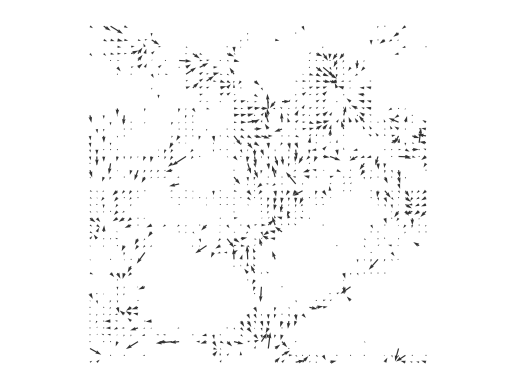

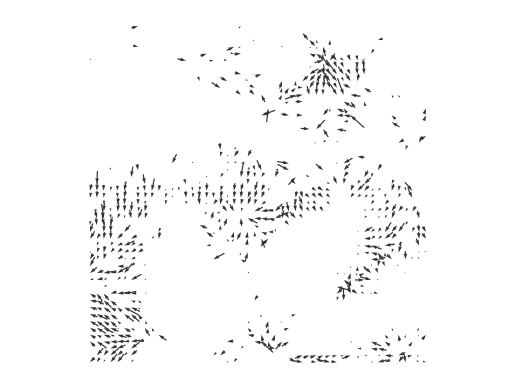

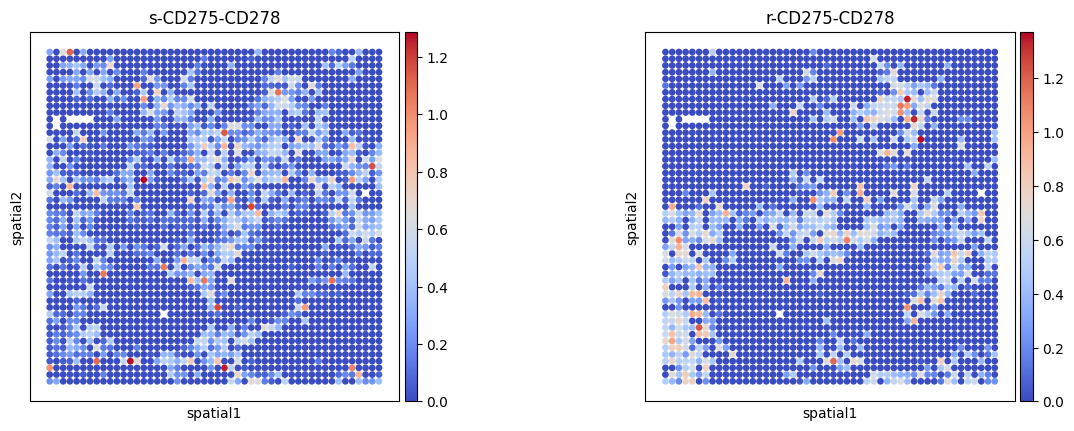

In [46]:
# CCC analysis
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/HumanTonsil2023/02_proteomic_profiles")
scp_adata = sc.read_h5ad("03_benchmark_methods/exp_ref46/SpatialDC/SpatialDC_reconstruct_not_norm.h5ad")

# set zero of cellperc<0
set_zero = scp_adata.obs["cellperc"] < 0.01
temp_arr = np.array(scp_adata.to_df())
temp_arr[set_zero,:]=0
scp_adata.X = temp_arr

sender_cell = "DC"
sender_pid = "CD275" # ICOSL
receiver_cell = "Naive CD4 T"
receiver_pid = "CD278" #ICOS

keep_index = scp_adata.var["name2"].isin([sender_pid,receiver_pid])
keep_ct = scp_adata.obs["celltype"].isin([sender_cell])
target_adata = scp_adata[keep_ct,keep_index].copy()

temp_index = [f"spot_{i}" for i in range(target_adata.shape[0])]
target_adata.obs.index = temp_index

temp_df = target_adata.to_df()

keep_index = scp_adata.var["name2"].isin([receiver_pid])
keep_ct = scp_adata.obs["celltype"].isin([receiver_cell])
temp_df[receiver_pid]  = scp_adata[keep_ct,keep_index].to_df().values
target_adata.X = np.array(temp_df)

# prepare adata
target_adata.obs[["Y"]] = -target_adata.obs[["Y"]]
target_adata.obsm["spatial"] = np.array(target_adata.obs[["X","Y"]])
sc.pp.log1p(target_adata)

target_ppi_df = pd.DataFrame({0:sender_pid,1:receiver_pid,2:'sig_ppi',3:'Secreted Signaling'},index=[0,1,2,3])
ct.tl.spatial_communication(target_adata,
    database_name='selected_db', df_ligrec=target_ppi_df, dis_thr=500, heteromeric=True, pathway_sum=True) 

ct.tl.communication_direction(target_adata, database_name='selected_db', pathway_name='sig_ppi', k=5)

ct.pl.plot_cell_communication(target_adata, database_name='selected_db', pathway_name='sig_ppi',normalize_v=True,normalize_v_quantile=0.995,summary="sender",
grid_density=0.4,scale=0.5,ndsize=0,grid_thresh=10,grid_scale=10,filename=f"{sender_cell}_{receiver_cell}_sender_0.5.pdf",plot_method="cell")

ct.pl.plot_cell_communication(target_adata, database_name='selected_db', pathway_name='sig_ppi',normalize_v=True,normalize_v_quantile=0.995,clustering=None,summary="receiver",
grid_density=0.4,scale=0.5,ndsize=0,grid_thresh=10,grid_scale=10,filename=f"{sender_cell}_{receiver_cell}_receiver_0.5.pdf",plot_method="cell")

target_adata.obs[["Y"]] = -target_adata.obs[["Y"]]
target_adata.obsm["spatial"] = np.array(target_adata.obs[["X","Y"]])
target_adata.obs[f's-{sender_pid}-{receiver_pid}'] = target_adata.obsm['commot-selected_db-sum-sender'][f's-{sender_pid}-{receiver_pid}']
target_adata.obs[f'r-{sender_pid}-{receiver_pid}'] = target_adata.obsm['commot-selected_db-sum-receiver'][f'r-{sender_pid}-{receiver_pid}']
sc.pl.spatial(target_adata,spot_size=1,color=[f's-{sender_pid}-{receiver_pid}',f'r-{sender_pid}-{receiver_pid}'],cmap="coolwarm",save=f"{sender_cell}_{receiver_cell}_strength.pdf")

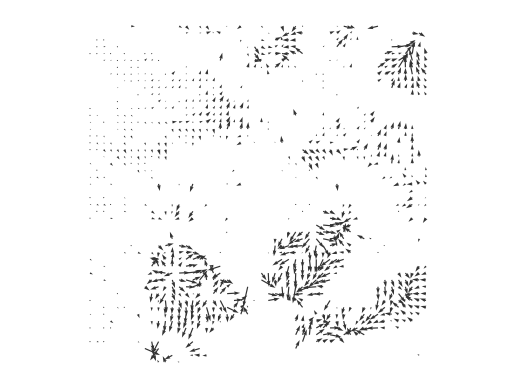

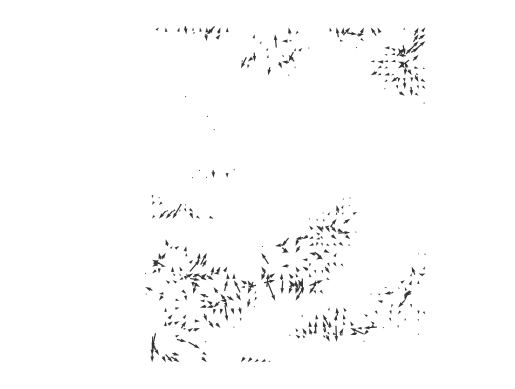

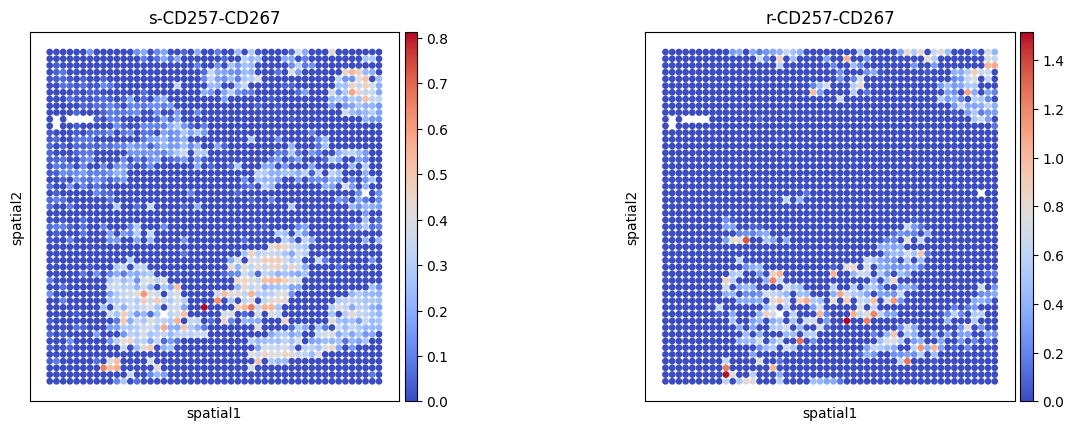

In [47]:
# PPI for FDC and GCBC
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/Manuscript_V20241119/HumanTonsil2023/02_proteomic_profiles")
scp_adata = sc.read_h5ad("03_benchmark_methods/exp_ref46/SpatialDC/SpatialDC_reconstruct_not_norm.h5ad")

# set zero of cellperc<0
set_zero = scp_adata.obs["cellperc"] < 0.01
temp_arr = np.array(scp_adata.to_df())
temp_arr[set_zero,:]=0
scp_adata.X = temp_arr

sender_cell = "FDC"
sender_pid = "CD257" # TNFSF13B
receiver_cell = "GCBC"
receiver_pid = "CD267" #TNFRSF13B

keep_index = scp_adata.var["name2"].isin([sender_pid,receiver_pid])
keep_ct = scp_adata.obs["celltype"].isin([sender_cell])
target_adata = scp_adata[keep_ct,keep_index].copy()

temp_index = [f"spot_{i}" for i in range(target_adata.shape[0])]
target_adata.obs.index = temp_index

temp_df = target_adata.to_df()

keep_index = scp_adata.var["name2"].isin([receiver_pid])
keep_ct = scp_adata.obs["celltype"].isin([receiver_cell])
temp_df[receiver_pid]  = scp_adata[keep_ct,keep_index].to_df().values
target_adata.X = np.array(temp_df)

# prepare adata
target_adata.obs[["Y"]] = -target_adata.obs[["Y"]]
target_adata.obsm["spatial"] = np.array(target_adata.obs[["X","Y"]])
sc.pp.log1p(target_adata)

target_ppi_df = pd.DataFrame({0:sender_pid,1:receiver_pid,2:'sig_ppi',3:'Secreted Signaling'},index=[0,1,2,3])
ct.tl.spatial_communication(target_adata,
    database_name='selected_db', df_ligrec=target_ppi_df, dis_thr=500, heteromeric=True, pathway_sum=True) 

ct.tl.communication_direction(target_adata, database_name='selected_db', pathway_name='sig_ppi', k=5)

ct.pl.plot_cell_communication(target_adata, database_name='selected_db', pathway_name='sig_ppi',normalize_v=True,normalize_v_quantile=0.995,summary="sender",
grid_density=0.4,scale=0.5,ndsize=0,grid_thresh=10,grid_scale=10,filename=f"{sender_cell}_{receiver_cell}_sender_0.5.pdf",plot_method="cell")

ct.pl.plot_cell_communication(target_adata, database_name='selected_db', pathway_name='sig_ppi',normalize_v=True,normalize_v_quantile=0.995,clustering=None,summary="receiver",
grid_density=0.4,scale=0.5,ndsize=0,grid_thresh=10,grid_scale=10,filename=f"{sender_cell}_{receiver_cell}_receiver_0.5.pdf",plot_method="cell")

target_adata.obs[["Y"]] = -target_adata.obs[["Y"]]
target_adata.obsm["spatial"] = np.array(target_adata.obs[["X","Y"]])
target_adata.obs[f's-{sender_pid}-{receiver_pid}'] = target_adata.obsm['commot-selected_db-sum-sender'][f's-{sender_pid}-{receiver_pid}']
target_adata.obs[f'r-{sender_pid}-{receiver_pid}'] = target_adata.obsm['commot-selected_db-sum-receiver'][f'r-{sender_pid}-{receiver_pid}']
sc.pl.spatial(target_adata,spot_size=1,color=[f's-{sender_pid}-{receiver_pid}',f'r-{sender_pid}-{receiver_pid}'],cmap="coolwarm",save=f"{sender_cell}_{receiver_cell}_strength.pdf")
